## Import Required Libraries

In [27]:
import os
import time
import json
import numpy as np 
import pandas as pd  
import itertools  
from collections import Counter  
import matplotlib.pyplot as plt 
from sklearn.metrics import (accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score) 
from datasets import Dataset, Image, ClassLabel
# from transformers import ( TrainingArguments,Trainer,ViTImageProcessor,ViTForImageClassification,DefaultDataCollator)
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
from torch import optim 
from torch.optim import lr_scheduler 
from torchvision import models 
from torchvision import transforms 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from torch.utils.data import DataLoader  
from torchvision.transforms import ( CenterCrop,Compose,Normalize,RandomRotation,RandomResizedCrop,RandomHorizontalFlip,RandomAdjustSharpness,Resize,ToTensor )
import warnings  
warnings.filterwarnings("ignore")  

## Introduction

With the rapid advancement of deep learning technology, the creation of realistic fake content has become increasingly prevalent. As a result, DeepFake detection has emerged as a prominent area of research. In this course project, we are presented with a task of detecting DeepFakes using three-channel facial images in a size of 317x317 pixels as inputs. Our objective is to train a representative model on the provided training set and achieve the highest possible accuracy on the test set.

To tackle this typical image classification problem, we have opted for a cutting-edge solution: deep neural networks.

## Data integration


In this section, we'll discuss the process of data integration for both **binary classification and multilabel classification**.

In [28]:
root_folder_path = ["/kaggle/input/deepfake-detection/train","/kaggle/input/deepfake-detection/val"]

### Binary Classification


#### Objective:
The objective of binary classification is to label images as either **real or fake**.

#### Label Semantic Attributes:

- 0: Real

- 1: Fake

#### Data Frame Creation:
To create the data frame for binary classification, we use the function `createDF_binary()`. This function traverses through the root folder paths and performs the following steps:

1. Initialize empty lists to store the image paths, labels, and manipulation labels.

2. Traverse through the subfolders in the root folder.
   - If the subfolder name contains "Fake", iterate through the images and add their paths, a binary label of 1 (indicating fake), and the manipulation label to the respective lists.
   - If the subfolder name does not contain "Fake", traverse through the sub-subfolders and add the paths of the images, a binary label of 0 (indicating real), and the manipulation label to the respective lists.


3. Create a data frame named `traindf` and `testdf` from the lists of image paths, manipulation labels, and labels for the training and test data

   - The created data frame includes the columns "image" (image path), "manipulation_labels" (manipulation label), and "label" (binary label).


4. Return the `traindf` and `testdf` data frames.

In [29]:
def createDF_binary():
    
    for path_1 in root_folder_path:
        file_names = []
        labels = []
        manipulation_labels =[]
        for folder_1 in os.listdir(path_1):
            if folder_1 != ".DS_Store":
                path_2 = os.path.join(path_1, folder_1)
                for folder_2 in os.listdir(path_2):
                    if folder_2 != ".DS_Store":
                        path_3 = os.path.join(path_2, folder_2)
                        for folder_3 in os.listdir(path_3):
                            if folder_3 != ".DS_Store":
                                path_4 = os.path.join(path_3, folder_3)
                                if "Fake" in folder_1: 
                                    for image in os.listdir(path_4):
                                        if image != ".DS_Store":
                                            file_names.append(str(os.path.join(path_4, image)))
                                            labels.append(1)
                                            manipulation_labels.append(folder_1.split("-")[1])
                                else:
                                    for folder_4 in os.listdir(path_4):
                                        if folder_4 != ".DS_Store":
                                            path_5 = os.path.join(path_4, folder_4)
                                            for image in os.listdir(path_5):
                                                if image != ".DS_Store":
                                                    file_names.append(str(os.path.join(path_5, image)))
                                                    labels.append(0)
                                                    manipulation_labels.append(folder_1.split("-")[1])

        
        if path_1 == "/kaggle/input/deepfake-detection/train":                          
            traindf = pd.DataFrame.from_dict({"image": file_names, "manipulation_labels":manipulation_labels, "label": labels})
        else:
            testdf = pd.DataFrame.from_dict({"image": file_names, "manipulation_labels":manipulation_labels, "label": labels})
    return traindf, testdf



### Multilabel Classification

#### Label Semantic Attributes:

- 0: Real
- 1: Fake, Identity
- 2: Fake, Expression, Identity
- 3: Fake, Expression, Head Pose

#### Data Frame Creation:

To create the data frame for multilabel classification, we use the function `createDF_4labels()`. This function traverses through the root folder paths and similar to `createDF()` function.


In [30]:
def createDF_4labels():

    for path_1 in root_folder_path:
        file_names = []
        labels = []
        manipulation_labels =[]
        for folder_1 in os.listdir(path_1):
            if folder_1 != ".DS_Store":
                path_2 = os.path.join(path_1, folder_1)
                for folder_2 in os.listdir(path_2):
                    if folder_2 != ".DS_Store":
                        path_3 = os.path.join(path_2, folder_2)
                        for folder_3 in os.listdir(path_3):
                            if folder_3 != ".DS_Store":
                                path_4 = os.path.join(path_3, folder_3)
                                if "Fake" in folder_1:
                                    idx = int(folder_1[-1])
                                    if idx==1 or idx ==2:
                                        cat = 1
                                    elif idx==3 or idx ==4:
                                        cat = 2
                                    else:
                                        cat = 3
                                    for image in os.listdir(path_4):
                                        if image != ".DS_Store":
                                            file_names.append(str(os.path.join(path_4, image)))
                                            labels.append(cat)
                                            manipulation_labels.append(folder_1.split("-")[1])
                                else:
                                    for folder_4 in os.listdir(path_4):
                                        if folder_4 != ".DS_Store":
                                            path_5 = os.path.join(path_4, folder_4)
                                            for image in os.listdir(path_5):
                                                if image != ".DS_Store":
                                                    file_names.append(str(os.path.join(path_5, image)))
                                                    labels.append(0)
                                                    manipulation_labels.append(folder_1.split("-")[1])

        
        if path_1 == "/kaggle/input/deepfake-detection/train":                          
            traindf = pd.DataFrame.from_dict({"image": file_names, "manipulation_labels":manipulation_labels, "label": labels})
        else:
            testdf = pd.DataFrame.from_dict({"image": file_names, "manipulation_labels":manipulation_labels, "label": labels})
    return traindf, testdf



In [31]:
traindf_4labels, testdf_4labels = createDF_4labels() # multilabel classification

traindf, testdf = createDF_binary() #binary

traindf = traindf.drop(['manipulation_labels'], axis=1)
testdf = testdf.drop(['manipulation_labels'], axis=1)

In [32]:
traindf.to_csv('/kaggle/working/data.txt', sep='\t', index=False)

## Class Distribution

We'll discuss the process of visualizing the class distribution in the training and testing datasets.

The `class_distribution()` function takes two parameters: `train` and `test`. These parameters represent the training and testing data frames, respectively.

In [33]:

def class_distribution(train, test):
    # Calculate class frequencies
    train_class_counts = train['label'].value_counts()
    test_class_counts = test['label'].value_counts()

    # Plotting class distribution for train and test sets side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    train_class_counts.plot(kind='bar', color='skyblue', ax=ax1)
    ax1.set_title('Train Set Class Distribution')
    ax1.set_xlabel('Class Label')
    ax1.set_ylabel('Count')

    test_class_counts.plot(kind='bar', color='salmon', ax=ax2)
    ax2.set_title('Test Set Class Distribution')
    ax2.set_xlabel('Class Label')
    ax2.set_ylabel('Count')

    plt.tight_layout()
    plt.show()



#### Binary Class Distribution (2 labels)

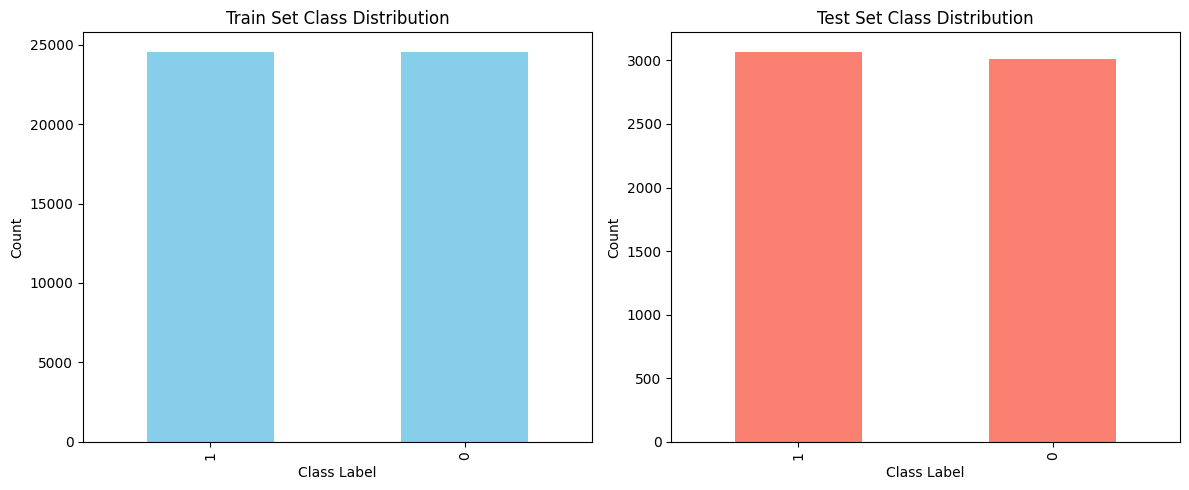

In [34]:
class_distribution(traindf, testdf)

#### Multilabel Class Distribution (4 labels)class_distribution(4 labels)

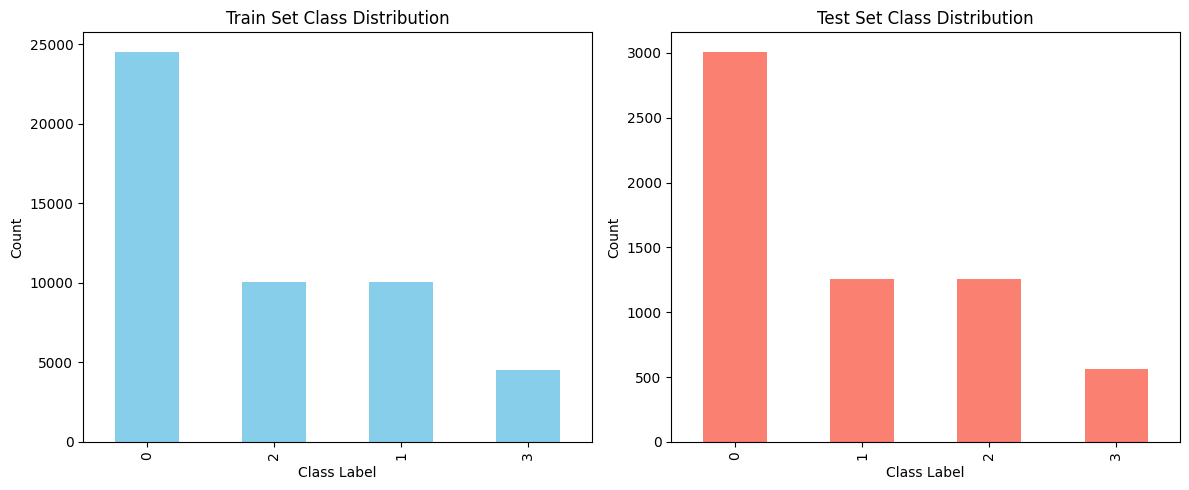

In [35]:
class_distribution(traindf_4labels, testdf_4labels)

## Data Preprocessing

### Image Transformers

The code defines two sets of image transformers: `train_transform` and `val_transform`. These transformers are created using the `transforms.Compose()` function from the `torchvision.transforms` module. They apply a series of transformations to the input images in a sequential manner.

#### Training Image Transformers (`train_transform`)

1. Resize: The images are resized to a dimension of specific pixels.

2. Center Crop: A center crop of size specific pixels is applied to the resized images.

3. Random Horizontal Flip: The images are randomly flipped horizontally with a probability of 0.5.

4. Random Rotation: The images are randomly rotated by a maximum of 10 degrees.

5. Random Grayscale: The images are randomly converted to grayscale with a probability of 0.2.

6. Random Gaussian Blur: The images are randomly blurred using Gaussian blur with a kernel size of 11 and a standard deviation of 10.

7. To Tensor: The images are converted to PyTorch tensors.

8. Normalization: The pixel values of the images are normalized using the mean and standard deviation values of [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225], respectively.

#### Validation Image Transformers (`val_transform`)

1. Resize: The images are resized to a dimension of specific pixels.

2. Center Crop: A center crop of size specific pixels is applied to the resized images.

3. To Tensor: The images are converted to PyTorch tensors.

4. Normalization: The pixel values of the images are normalized using the mean and standard deviation values.


**The transformers allow us to resize, crop, normalize, and apply data augmentation techniques to the images.**

In [36]:
# define img transformers and create dataLoaders
train_tranform = transforms.Compose([
    # inceptionV3
    transforms.Resize(299),
    transforms.CenterCrop(299),
    
    # ResNet18 & VGG16
#     transforms.Resize(256),
#     transforms.CenterCrop(224),    
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.RandomRotation(degrees=10, expand=False, fill=None),
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.2),
#     transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0)],p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(11, 10)],p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# from official  documentation
])
val_tranform = transforms.Compose([
    # inceptionV3
    transforms.Resize(299),
    transforms.CenterCrop(299),
    
    # ResNet18 & VGG16
#     transforms.Resize(256),
#     transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# from official  documentation
])

## Dataset Class

We define a custom dataset class called `Dataset` that inherits from the `torch.utils.data.Dataset` class. This class is used to load and preprocess the image data for training and testing.

In [37]:
class Dataset(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        image = Image.open(self.img_data.loc[index, 'image'])
        image = image.convert('RGB')
# #         image = image.resize((317,317))
# #         image = image.resize((256,256))
#         image = image.resize((299,299))
        label = torch.tensor(self.img_data.loc[index, 'label'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label



train_dataset= Dataset(traindf,train_tranform)
test_dataset = Dataset(testdf,val_tranform)


## Data Loaders

The use of data loaders to load and iterate over preprocessed image data in batches during the training and validation process.

### Data Loader Settings


- Batch Size: The batch size is set to 64. This means that during each iteration, the data loader will return a batch of 64 samples.

- Shuffle Dataset: The `shuffle_dataset` parameter is set to `True`. This means that the data loader will shuffle the samples in the dataset before each epoch. Shuffling the dataset helps in randomizing the order of the samples and reduces the risk of the model learning any specific order-related patterns.

In [38]:
# DataLoader settings
batch_size = 64
shuffle_dataset = True

In [39]:
# Create data loaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_dataset)

## Visualization

### Display original and augmented images

Display both the original and augmented images from the dataset. This can help us visualize the effects of the data augmentation techniques applied to the images.

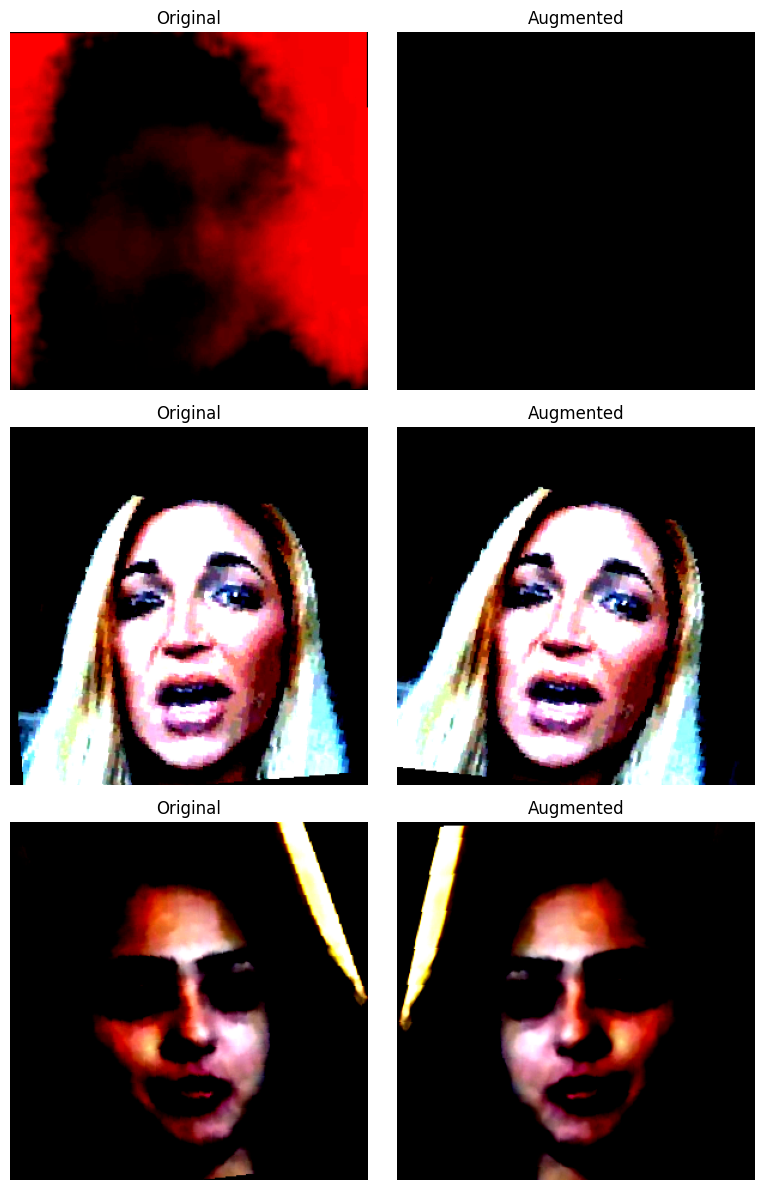

In [40]:

# Define a function to display original and augmented images
def display_augmented_images(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 12))

    for i in range(num_samples):
        # Select a random sample
        index = np.random.randint(len(dataset))
        original_image, _ = dataset[index]

        # Plot original image
        axes[i, 0].imshow(np.transpose(original_image.numpy(), (1, 2, 0)))
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Plot augmented image
        augmented_image, _ = dataset[index]
        axes[i, 1].imshow(np.transpose(augmented_image.numpy(), (1, 2, 0)))
        axes[i, 1].set_title('Augmented')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Display original and augmented images
display_augmented_images(train_dataset)


### Display Real and Fake images

In addition to displaying the augmented images, we can also display a subset of the real and fake images from the dataset. This can provide us with a visual representation of the distribution of real and fake images and help us understand the characteristics of the data.

To display the real and fake images, we can filter the dataset based on the corresponding labels and select a few examples from each class. 

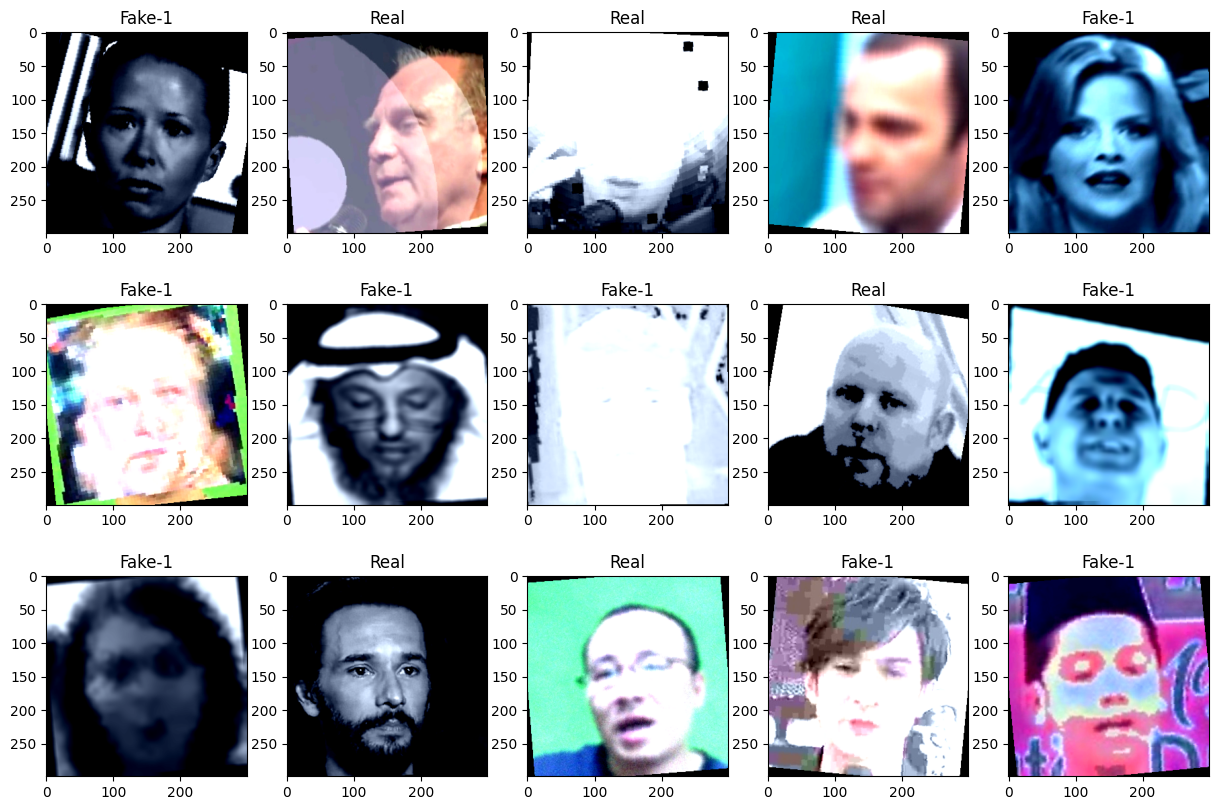

In [41]:

def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# arthopod_types = {0: 'Real', 1: 'Fake'}
arthopod_types = {0: 'Real'}
for i in range(1,4):
    arthopod_types[i]=f"Fake-{i}"
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label


## Define Pre-trained Model, Training Function and testing function

In this section, we define three pre-trained models for image classification: **ResNet18, VGG16, and InceptionV3**. We also define the training and testing functions to train and evaluate these models on our dataset.

### Pre-trained Models

1. **ResNet18**: This model uses the `resnet18` architecture, which is a popular convolutional neural network (CNN) model. We load the pre-trained ResNet18 model using `models.resnet18(pretrained=True)`. We modify the classifier for binary classification by replacing the fully connected (fc) layer with our own sequence of layers. 

2. **VGG16**: This model uses the `vgg16` architecture, another widely used CNN model. We load the pre-trained VGG16 model using `models.vgg16(pretrained=True)`. Similar to ResNet18, we modify the classifier for binary classification by replacing the last fc layer and adding an additional fc layer for flexibility.

3. **InceptionV3**: This model uses the `inception_v3` architecture. We load the pre-trained InceptionV3 model using `models.inception_v3(pretrained=True)`. We modify the classifier by replacing the last fc layer with our own sequence of layers. 

In [42]:
# Define the models
class ResNetModel(nn.Module):
    def __init__(self,dropout_rate=0.3):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Modify the classifier for binary classification
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),  # Additional layer for flexibility
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  # Dropout layer added
            nn.Linear(512, 2)  # Binary classification output
#             nn.Linear(512, 4)  # Multi-label classification output
        )
        
        
    def forward(self, x):
        return self.model(x)
        
    
class VGGModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(VGGModel, self).__init__()
        self.model = models.vgg16(pretrained=True)
        # Modify the classifier for binary classification
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, 2)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.classifier[-1].in_features, 512),  # Additional layer for flexibility
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  #Drop out layer added
            nn.Linear(512, 2)  # Binary classification output
#             nn.Linear(512, 4)  # Multi-label classification output
        )
        
    def forward(self, x):
        return self.model(x)

class InceptionModel(nn.Module):
    def __init__(self,dropout_rate=0.3):
        super(InceptionModel, self).__init__()
        self.model = models.inception_v3(pretrained=True)
        
        #  Modify the classifier for binary classification
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 512),  # Additional layer for flexibility
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  #Drop out layer added
            nn.Linear(512, 2)  # Binary classification output
#             nn.Linear(512, 4)  # Multi-label classification output
        )
        
        self.model.aux_logits = False

    def forward(self, x):
        return self.model(x)


In [43]:
resnet_save_path = "/kaggle/working/resnet_model"
Vgg_save_path = "/kaggle/working/vgg_model"
inception_save_path = "/kaggle/working/inception_model"
regnet_save_path = "/kaggle/working/regnet_model"

### Training Function and Testing Function

1. **Key Points**:  when calcluating accuracy, couting subclass 'fake-1', 'fake-2', and 'fake-3' as a whole class 'fake'. But when calculaing loss, each 'fake' subclass is considered as a sepreate class.

2. **Training Function**: The training function takes as input the model, training dataset, validation dataset, loss function, optimizer, number of epochs, and early stopping criteria. It iterates over the training dataset for the specified number of epochs, performing the following steps:
   - Forward pass: Passes the input batch through the model to obtain the predicted outputs.
   - Calculate loss: Compares the predicted outputs with the ground truth labels using the specified loss function.
   - Backward pass: Computes the gradients of the model parameters with respect to the loss and updates the parameters using the optimizer.
   - Update metrics: Keeps track of the training loss and accuracy for monitoring the model's performance.
   - **Early stopping**: Checks if the validation loss does not improve for a specified number of epochs and stops training if the criteria are met.
   - Print progress: Outputs the training and validation loss and accuracy for each epoch.
   - Returns the trained model and the training history (loss and accuracy).


3. **Testing Function**: The testing function takes as input the trained model and the testing dataset. It evaluates the model's performance on the testing dataset by performing the following steps:
   - Forward pass: Passes the input batch through the model to obtain the predicted outputs.
   - Calculate metrics: Computes the testing loss and accuracy using the predicted outputs and the ground truth labels.
   - Print results: Outputs the testing loss and accuracy.
   - Returns the testing loss and accuracy.


In [44]:


def makeIntoBinary(tensor):
    tensor[tensor > 0] = 1


train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Training function
def train_model(model, criterion, optimizer, scheduler,path_prefix, num_epochs=25, patience=7):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            makeIntoBinary(labels)
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            
            
            makeIntoBinary(preds)
            
            running_corrects += torch.sum(preds == labels.data)
            
        
        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_acc_history.append(epoch_acc.cpu().numpy().item())
        train_loss_history.append(epoch_loss)

        print(f'Train Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                makeIntoBinary(val_labels)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                
                _, val_preds = torch.max(val_outputs, 1)
                
                makeIntoBinary(val_preds)
                
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        val_epoch_loss = val_running_loss / len(test_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(test_loader.dataset)

        val_acc_history.append(val_epoch_acc.cpu().numpy().item())
        val_loss_history.append(val_epoch_loss)

        print(f'Val Epoch {epoch}/{num_epochs - 1} Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {patience} epochs of no improvement.')
                break
                
        torch.save(model.state_dict(),f"{path_prefix}_{epoch}.pt")

    model.load_state_dict(best_model_wts)
    
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history





In [45]:
# Evaluate function
def test(model, dataloader):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

    model.eval()
    accuracy = 0
    recall = 0
    precision = 0
    auc = 0
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            makeIntoBinary(labels)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            
            makeIntoBinary(preds)
            
            
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
    all_labels_list = []
    for i in all_labels:
        all_labels_list.append(i.item())
    all_preds_list = []
    for i in all_preds:
        all_preds_list.append(i.item())
        
    accuracy = running_corrects.double() / len(dataloader.dataset)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, AUC: {auc:.4f}')
    
    return accuracy, recall, precision, auc, all_preds_list, all_labels_list

## Tuning parameters

To further improve the performance of the models, we can tune various hyperparameters. Here are some key parameters that can be tuned:

1. **Learning Rate**: The learning rate determines the step size at which the optimizer updates the model parameters during training. We will try different learning rates to find the optimal value for the specific dataset and model architecture.

2. **Regularization Techniques**: Regularization techniques such as dropout and weight decay can help prevent overfitting. Dropout randomly sets a fraction of input units to zero during training, which helps the model generalize better. Weight decay adds a penalty term to the loss function, encouraging the model to have smaller weights. These techniques can be adjusted by tuning the dropout rate and weight decay factor.

3. **Optimizer**: The choice of optimizer affects how the model parameters are updated during training. Popular optimizers include stochastic gradient descent (SGD), and Adam. Each optimizer has its own hyperparameters, such as momentum, learning rate decay, and weight decay, which can be tuned to improve training performance.

4. **Gamma and Step Size**: Gamma and step size are specific parameters used in learning rate scheduling techniques, such as step decay or exponential decay. Gamma defines the factor by which the learning rate is reduced at each step, while step size determines the number of epochs after which the learning rate is reduced. These parameters can be adjusted to control the learning rate schedule and potentially improve the model's ability to converge.

### Final selected model

| Pre-trained Model | Binary/Multilabel | Learning rate | gamma | Step size | Weight decay | Drop out rate | Best validation accuracy | AUC      |
|-------------------|------------------|---------------|-------|-----------|--------------|---------------|-------------------------|----------|
| InceptionV3       | Binary           | 0.0001        | 0.5   | 5         | 1e-4         | 0.3           | 96.3786                 | 96.34086 |

### Slecting Progress

#### Common parameters

epsilon = 1e-08

momentum = 0.9

criterion = nn.CrossEntropyLoss()

learning scheduler: stepLR

#### First Trial

Due to the long training time, we won't further train the network based on VGG16.

| Pre-trained Model | Input size | Optimizer | Learning rate | gamma | Step size | Weight decay | Drop out | Best epoch | Total epoches | Best validation accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Resnet18 | 317x317 | Adam | 0.001 | 0.1 | 7 | 1e-4 | 0 | 18 | 20 | 81.0864 |
| VGG16 | 317x317 | SGDM | 0.001 | 0.1 | 7 | 1e-4 | 0 | 15 | 15 | 90.3704 |
| InceptionV3 | 317x317 | Adam | 0.001 | 0.1 | 7 | 1e-4 | 0 | 20 | 20 | 74.6831 |

#### Second Trial

1. Change input size to same as the one pre-train model used for training
2. Make step size and learning rate smaller.
3. Add early stopping.

Observation: accuracy is improved a lot.

| Pre-trained Model | Input size | Optimizer | Learning rate | gamma | Step size | Weight decay | Drop out rate | Best validation accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Resnet18 | 256x256 | Adam | 0.0001 | 0.1 | 5 | 1e-4 | 0 | 92.164 |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.1 | 5 | 1e-4 | 0 | 95.390 |

­­

#### Third Trial

Add dropout

| Pre-trained Model | Input size | Optimizer | Learning rate | gamma | Step size | Weight decay | Dropout rate | Best validation accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Resnet18 | 256x256 | Adam | 0.0001 | 0.1 | 5 | 1e-4 | 0.3 | 93.9588 |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.1 | 5 | 1e-4 | 0.3 | 95.1112 |

#### Fourth Trial

1. Change the dropout rate from 0.3 to 0.5 on ResNet18
2. Trying to use SGD on ResNet18

Observation: accuracy becomes quite lower.

| Pre-trained Model | Input size | Optimizer | Learning rate | gamma | Step size | Weight decay | Drop out rate | Best validation accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Resnet18 | 256x256 | SGDM | 0.0001 | 0.1 | 5 | 1e-4 | 0.5 | 60.6420 |
| Resnet18 | 256x256 | Adam | 0.0001 | 0.1 | 5 | 1e-4 | 0.5 | 91.1780 |

#### Fifth Trial

Change gamma,step size,and weight decay for inceptionV3

Observation: accuracy becomes higher.

| Pre-trained Model | Input size | Optimizer | Learning rate | gamma | Step size | Weight decay | Drop out rate | Best validation accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.5 | 5 | 1e-4 | 0.5 | 96.3786 |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.5 | 3 | 1e-4 | 0.3 | 96.0329 |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.5 | 5 | 1e-4 | 0.8 | 95.5612 |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.5 | 5 | 1e-3 | 0.5 | 96.3045 |

#### Sixth Trial

Multi-label classification

Observation:

For ResNet18, accuracy becomes lower.

For InceptionV3, accuracy becomes higher.

| Pre-trained Model | Input size | Optimizer | Learning rate | gamma | Step size | Weight decay | Drop out rate | Best validation accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Resnet18 | 256x256 | Adam | 0.0001 | 0.1 | 5 | 1e-4 | 0.3 | 91.7860 |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.5 | 5 | 1e-4 | 0.3 | 96.4623 |

#### Final Round for best two model

Common setting

| Pre-trained Model | Input size | Optimizer | Learning rate | gamma | Step size | Weight decay | Drop out rate |
| --- | --- | --- | --- | --- | --- | --- | --- |
| InceptionV3 | 299x299 | Adam | 0.0001 | 0.5 | 5 | 1e-4 | 0.3 |

Comparison

| Pre-trained Model | Binary/Multi-label | Best validation accuracy | Test accuracy | Recall | Precision | AUC |
| --- | --- | --- | --- | --- | --- | --- |
| InceptionV3 | Binary | 96.3786 | 96.3457 | 96.837 | 95.9612 | 96.34086 |
| InceptionV3 | Multilabel | 96.4623 | 96.2634 | 95.8265 | 96.7413 | 96.2677 |

#### Final selection:
The multilabel one has higher validation accuracy, and higher recall, indetifying better fake images.
However, the binary one is finally chosen, due to its sightly higher test accuracy and AUC. 


In [46]:
#common parameters
epsilon = 1e-08

momentum = 0.9

criterion = nn.CrossEntropyLoss()

In [47]:
#final selection
learning_rate = 0.0001
weight_decay = 1e-4
step_size = 5
gamma = 0.5


## Training

In [48]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inception_model = InceptionModel().to(device)
optimizer_inception = optim.Adam(inception_model.parameters(), lr=learning_rate, eps=epsilon, weight_decay=weight_decay)
# optimizer_SGD = optim.SGD(inception_model.parameters(), lr=learning_rate, weight_decay=weight_decay,momentum=0.9,nesterov=True)

exp_lr_scheduler_inception = lr_scheduler.StepLR(optimizer_inception, step_size=step_size, gamma=gamma)


In [49]:
# Train models
inception_model,inception_train_acc_history, inception_val_acc_history, inception_train_loss_history, inception_val_loss_history = train_model(inception_model, criterion, optimizer_inception, exp_lr_scheduler_inception,inception_save_path, num_epochs=30)
torch.save(inception_model.state_dict(), inception_save_path)

## Evaluation

In [58]:
# Load Model
inception_model = InceptionModel().to(device)
inception_model.load_state_dict(torch.load(inception_save_path))

<All keys matched successfully>

In [ ]:

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

inception_accuracy, inception_recall, inception_precision, inception_auc,inception_test_preds, inception_test_targets = test(inception_model, test_loader)
    
inception_result = {"train_acc_history":inception_train_acc_history,
                "val_acc_history":inception_val_acc_history,
                "train_loss_history":inception_train_loss_history,
                "val_loss_history":inception_val_loss_history,
                "accuracy":inception_accuracy.cpu().numpy().item(),
                "recall":inception_recall,
                "precision":inception_precision,
                "auc":inception_auc,
                "test_preds":inception_test_preds,
                "test_targets":inception_test_targets}

    
with open("/kaggle/working/inception_result.json", "w") as outfile: 
    json.dump(inception_result, outfile)


In [54]:
# Function to plot training history
def plot_training_history(model_name, train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{model_name} - Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()

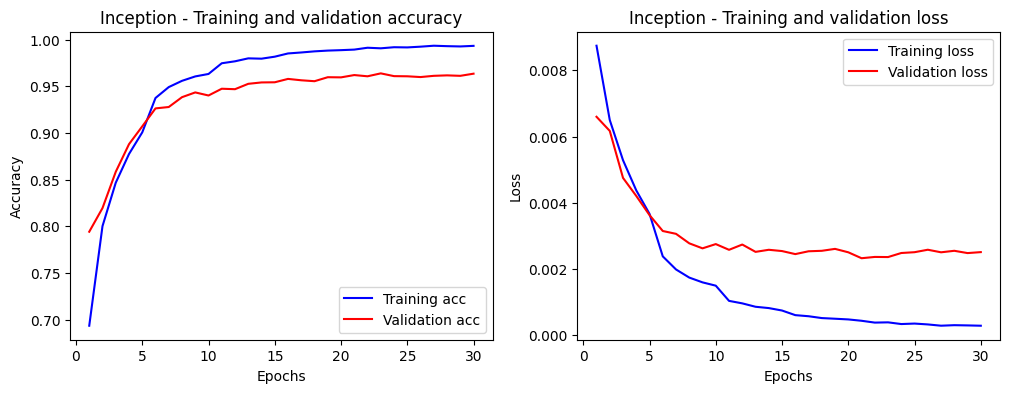

In [55]:

plot_training_history("Inception",inception_result["train_acc_history"], inception_result["val_acc_history"], inception_result["train_loss_history"], inception_result["val_loss_history"])


### Training and Validation Accuracy

During the training process, the accuracy of the model on both the training and validation datasets is an important metric to monitor. 

Initially, as the training progresses, both the training and validation accuracy tend to increase. This indicates that the model is learning and improving its ability to classify the images correctly. 

Around 15 epochs into the training, we observe that the validation accuracy starts to show a slow improvement. This phenomenon is commonly referred to as "convergence slowdown." It indicates that the model has learned most of the relevant patterns in the data, and further improvements in accuracy become smaller with each subsequent epoch.

### Training and Validation Loss

The loss value quantifies the discrepancy between the predicted outputs and the ground truth labels. When examining the training and validation loss, we observe a very small gap between the two values. A small gap between the training and validation losses is generally acceptable. 


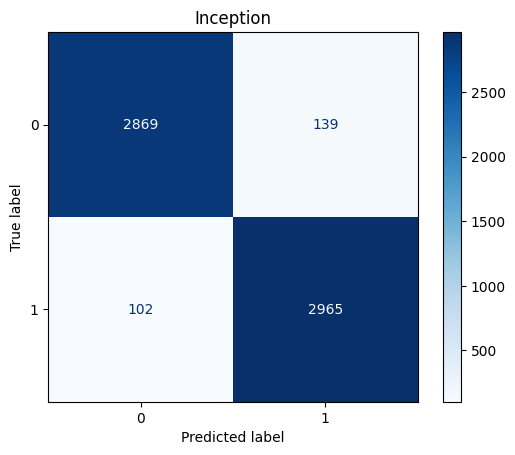

In [60]:

inception_conf_matrix = confusion_matrix(inception_test_targets, inception_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=inception_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("Inception")
plt.title("Inception")
plt.show()


## Discussion

### Further improvement for multilabel classification

### Imbalanced Data

One main issue in multilabel classification is imbalanced data, where the distribution of instances across different classes is significantly skewed. This can lead to biased predictions and reduced accuracy for the minority classes.


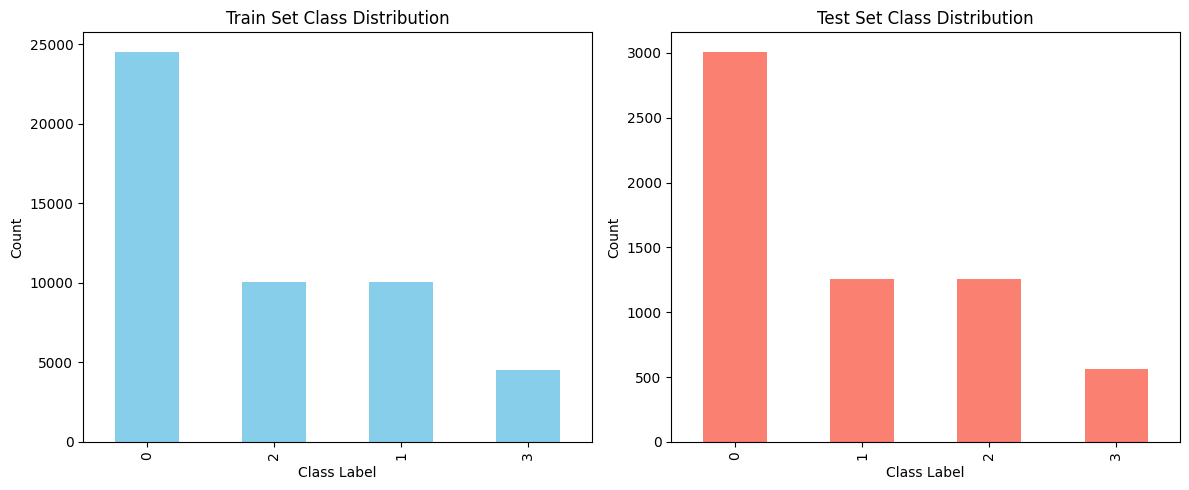

In [57]:
class_distribution(traindf_4labels, testdf_4labels)

To address this issue, we can employ the following strategies:

#### 1. Oversampling the Minority Class

Oversampling is a technique used to increase the number of instances in the minority class. By doing so, we provide the model with more examples from the underrepresented class, enabling it to learn better and make more accurate predictions. There are several oversampling methods that can be employed:

- **Random Oversampling**: This method randomly duplicates instances from the minority class until the distribution becomes more balanced. It is a simple and effective technique but may lead to overfitting if the minority class is overrepresented.

- **SMOTE (Synthetic Minority Over-sampling Technique)**: SMOTE generates synthetic samples for the minority class by interpolating between existing instances. It creates new samples by selecting a random instance from the minority class and computing the difference between that instance and its nearest neighbors. The synthetic samples are generated along the line segments joining the minority instance and its neighbors.

- **ADASYN (Adaptive Synthetic Sampling)**: ADASYN is an extension of SMOTE that adapts the generation of synthetic samples based on the difficulty of learning the minority instances. It focuses more on those instances that are harder to learn, resulting in a more balanced distribution.

#### 2. Adjusting Loss Function Weights

Another approach to address class imbalance is to adjust the weights of the loss function. By assigning higher weights to the minority class, we encourage the model to focus more on correctly classifying those instances. There are different ways to adjust loss function weights:

- **Weighted Loss**: Assign different weights to each class in the loss function, with higher weights for the minority class and lower weights for the majority class. This amplifies the loss contribution from the minority class, making it more influential during training.

- **Class-specific Loss**: Use class-specific loss functions instead of a single loss function for all classes. This approach allows customization of the loss function for each class, targeting the specific challenges associated with that class. We can assign different weights or use different loss functions for different classes based on their importance or difficulty.

### Parameter Tuning

Another aspect to consider for further improvement is parameter tuning. Fine-tuning the model's hyperparameters can significantly impact its performance. We can try different learning schedulers since only stepLR is used in our project.

#### Other

Setting the same random seed while training maybe helpful for later analysis. 



## Conclusion

In this project, we utilized multiple pre-trained image classification models, namely ResNet18, VGG16, and InceptionV3, to solve a multilabel classification problem. We trained these models in two ways: binary classification and multilabel classification.

To improve the models' performance, we conducted parameter tuning with a total of 14 trials. We experimented with different hyperparameter configurations and saved the logs for each trial to analyze the results.

The best-performing model, **inceptionV3, achieved an accuracy of 0.96**, and through parameter tuning and utilizing multiple pre-trained models, we aimed to further enhance the models' accuracy and overall performance.

## References

1. He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
2. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
3. Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.
4. PyTorch 1.10.0 documentation. (n.d.). Retrieved December 12, 2023, from https://pytorch.org/docs/stable/index.html.